In [83]:
import pandas as pd
import pickle
import numpy as np
import xgboost
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold,StratifiedShuffleSplit
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score,roc_auc_score, roc_curve, average_precision_score,precision_recall_curve
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
pd.set_option("display.max_columns",80)

In [2]:
dataset = r"E:\StudyLAB\1_2564\499\dataset\test_multi.csv"
df = pd.read_csv(dataset)
df = df.dropna(how='any',axis=0)
df.shape

(1591, 10)

In [18]:
cm_field = ['ROAD_TYPE','SURFACE','ONEWAY','LANE']
df_cm = pd.get_dummies(df,columns=cm_field)
cm_feature_names = pd.get_dummies(df[cm_field],columns=cm_field).columns.tolist()
df_cm.head(30)
# print(cm_feature_names)

,NUMACC,distance,rain,temperatur,wind,Speed,ROAD_TYPE_1,ROAD_TYPE_2,ROAD_TYPE_3,ROAD_TYPE_5,ROAD_TYPE_6,ROAD_TYPE_7,ROAD_TYPE_8,ROAD_TYPE_9,SURFACE_1,SURFACE_2,SURFACE_9,ONEWAY_0,ONEWAY_1,LANE_1,LANE_2,LANE_3,LANE_4,LANE_6
0,2,174.60,2.22,27.82,3.80,45,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0
1,1,111.78,0.56,28.66,5.63,70,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0
2,1,92.26,2.50,27.84,7.13,45,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0
3,2,88.52,1.74,26.33,3.91,45,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0
4,0,67.56,3.58,27.01,3.63,80,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0
5,0,61.22,12.17,27.86,4.08,80,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0
6,1,334.34,1.70,28.97,3.29,45,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0
7,2,63.69,1.12,28.79,3.66,45,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0
8,0,63.69,1.64,26.42,3.06,70,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0
9,1,69.88,0.14,27.68,10.89,55,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0


In [4]:
df['Speed'].astype('float')

0       45.0
1       70.0
2       45.0
3       45.0
4       80.0
        ... 
1586    45.0
1587    80.0
1588    45.0
1589    45.0
1590    80.0
Name: Speed, Length: 1591, dtype: float64

In [5]:
df
float_feature_names =['distance','rain','temperatur','wind','Speed']

float_features = df_cm.xs(float_feature_names,axis=1).values
scaler = StandardScaler()
float_scaled = scaler.fit_transform(float_features)
print (float_features.mean(axis=0))

with open('scalers.pkl','wb') as fp:
    pickle.dump(scaler,fp)

[173.26080453   2.34109994  26.88800126   4.2772973   51.71590195]


In [6]:
y = df['NUMACC'].values
df_cm = df_cm.xs(float_feature_names+cm_feature_names,axis=1)

In [7]:
X= df_cm.values
y = df['NUMACC'].values
feature_names = df_cm.columns.tolist()


In [8]:
wrangler = {
    'scaler': scaler,
    'float_feature_names': float_feature_names,
    'cm_fields': cm_field,
    'feature_names': feature_names,
   
}
with open('wrangler_new.pkl','wb') as fp:
    pickle.dump(wrangler,fp)

In [68]:
feature_sel = range(len(feature_names))
#feature_sel = [-1,-2,-3]
Xs = X[:,feature_sel]
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.1)#, random_state=2)
fnames = np.array(feature_names)[feature_sel]



params = {
    'max_depth':6,
    'min_child_weight': 5.0,
    'reg_lambda': 1.0,
    'reg_alpha':0.0,
    'scale_pos_weight':1.0,
    'eval_metric':'auc',
    'objective':'multi:softmax',
    'eta':0.5,
    'num_class': 5
}

feature_sel = range(len(feature_names))
#feature_sel = [-1,-2,-3]
Xs = X[:,feature_sel]
print(Xs)
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.1)#, random_state=2)
fnames = np.array(feature_names)[feature_sel]

dtrain = xgboost.DMatrix(X_train,label=y_train,feature_names=fnames)
dtest =  xgboost.DMatrix(X_test,label=y_test,feature_names=fnames)


[[1.7460e+02 2.2200e+00 2.7820e+01 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [1.1178e+02 5.6000e-01 2.8660e+01 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [9.2260e+01 2.5000e+00 2.7840e+01 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 ...
 [1.5240e+02 1.2900e+00 2.5560e+01 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 [3.8600e+01 1.7000e-01 2.9240e+01 ... 1.0000e+00 0.0000e+00 0.0000e+00]
 [5.2770e+01 1.0400e+00 2.8560e+01 ... 0.0000e+00 0.0000e+00 0.0000e+00]]


In [69]:
booster = xgboost.train(params,dtrain,
    evals = [(dtest, 'eval')],
    num_boost_round=3000,
    early_stopping_rounds=25
)

[21:40:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	eval-auc:0.83197
[1]	eval-auc:0.87720
[2]	eval-auc:0.89357
[3]	eval-auc:0.89772
[4]	eval-auc:0.90536
[5]	eval-auc:0.90798
[6]	eval-auc:0.90835
[7]	eval-auc:0.91370
[8]	eval-auc:0.91332
[9]	eval-auc:0.91543
[10]	eval-auc:0.91635
[11]	eval-auc:0.92001
[12]	eval-auc:0.92380
[13]	eval-auc:0.92622
[14]	eval-auc:0.92900
[15]	eval-auc:0.92966
[16]	eval-auc:0.93110
[17]	eval-auc:0.92905
[18]	eval-auc:0.92885
[19]	eval-auc:0.92883
[20]	eval-auc:0.93171
[21]	eval-auc:0.93440
[22]	eval-auc:0.93399
[23]	eval-auc:0.93234
[24]	eval-auc:0.93276
[25]	eval-auc:0.93376
[26]	eval-auc:0.93337
[27]	eval-auc:0.9340

In [70]:
print(fnames)

['distance' 'rain' 'temperatur' 'wind' 'Speed' 'ROAD_TYPE_1' 'ROAD_TYPE_2'
 'ROAD_TYPE_3' 'ROAD_TYPE_5' 'ROAD_TYPE_6' 'ROAD_TYPE_7' 'ROAD_TYPE_8'
 'ROAD_TYPE_9' 'SURFACE_1' 'SURFACE_2' 'SURFACE_9' 'ONEWAY_0' 'ONEWAY_1'
 'LANE_1' 'LANE_2' 'LANE_3' 'LANE_4' 'LANE_6']


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

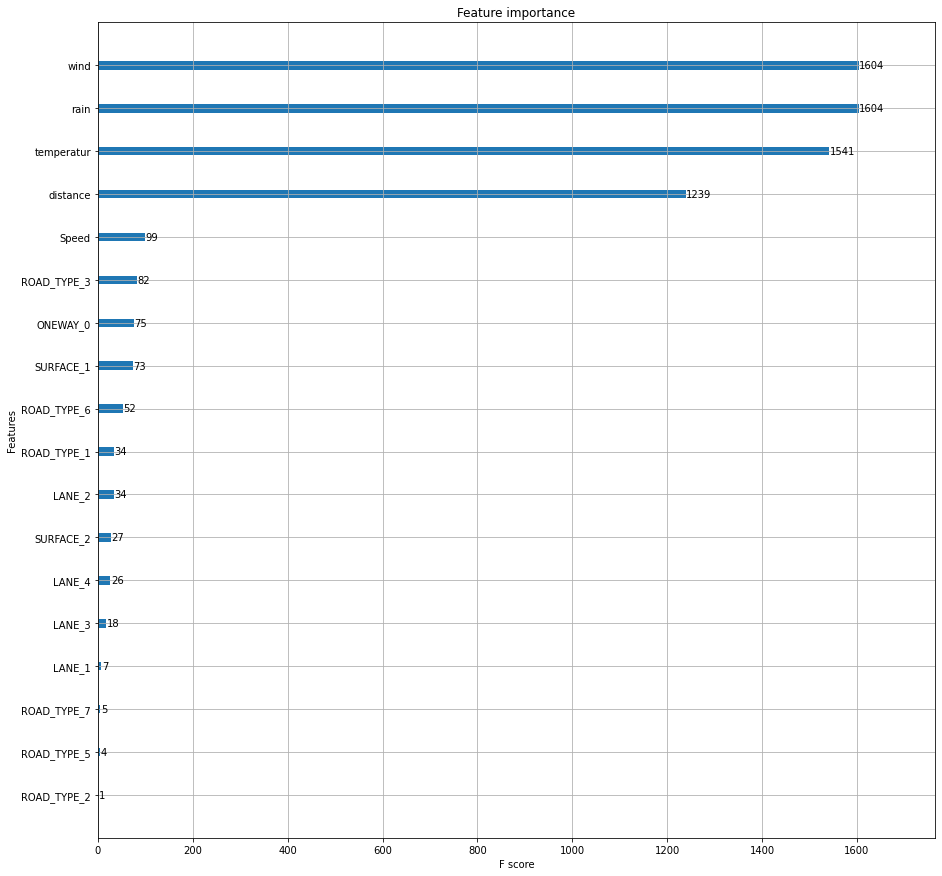

In [71]:
plt.figure(figsize=(15,15))
xgboost.plot_importance(booster,ax=plt.gca(),importance_type='weight')

In [72]:
booster.predict(dtest)

array([0., 2., 3., 0., 2., 2., 0., 1., 1., 0., 1., 4., 2., 0., 0., 1., 1.,
       1., 2., 4., 1., 0., 0., 0., 3., 1., 2., 0., 1., 1., 0., 2., 1., 4.,
       1., 0., 3., 0., 0., 0., 2., 1., 1., 0., 2., 1., 2., 0., 1., 0., 1.,
       0., 0., 0., 3., 0., 0., 1., 1., 2., 0., 0., 3., 0., 0., 2., 1., 0.,
       0., 0., 3., 1., 3., 1., 0., 1., 0., 3., 0., 1., 1., 0., 0., 1., 4.,
       0., 1., 0., 0., 3., 1., 1., 1., 1., 0., 0., 1., 0., 3., 2., 1., 3.,
       0., 1., 1., 1., 4., 1., 3., 0., 4., 1., 1., 0., 0., 4., 0., 3., 0.,
       1., 0., 1., 1., 1., 1., 1., 1., 0., 2., 0., 2., 1., 2., 1., 1., 3.,
       0., 1., 0., 0., 1., 0., 1., 1., 2., 1., 3., 0., 0., 1., 1., 1., 0.,
       3., 4., 1., 0., 3., 2., 1.], dtype=float32)

In [79]:
preds = booster.predict(dtest)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

Precision = 0.07125000000000001
Recall = 0.2
Accuracy = 0.35625


C:\Users\Baannana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [84]:
pred=booster.predict(dtest)
# Rs = r2_score(y_test, pred)
rmse=np.sqrt(mean_squared_error(y_test,pred))
# print('The R-squared is {:.4}'.format(Rs))
print('The root mean squared is {:.4}'.format(rmse))

The root mean squared is 0.6471


In [75]:
newdata = r"E:\StudyLAB\1_2564\499\dataset\newdata.csv"
df2 = pd.read_csv("demofile2_tem.csv")
df2 = df2.dropna(how='any',axis=0)
df2.head()

,distance,rain,temperatur,wind,Speed,ROAD_TYPE_1,ROAD_TYPE_2,ROAD_TYPE_3,ROAD_TYPE_5,ROAD_TYPE_6,ROAD_TYPE_7,ROAD_TYPE_8,ROAD_TYPE_9,SURFACE_1,SURFACE_2,SURFACE_9,ONEWAY_0,ONEWAY_1,LANE_1,LANE_2,LANE_3,LANE_4,LANE_6
0,31.66,4.11,26.12,4.18,80,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
1,84.61,0.70,26.64,3.33,45,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0


In [76]:
feature_sel = range(len(feature_names))
#feature_sel = [-1,-2,-3]
Xs = X[:,feature_sel]
fnames = np.array(feature_names)[feature_sel]
ddata = xgboost.DMatrix(df2,feature_names=fnames)
print(ddata)

In [78]:
booster.predict(ddata)


array([4., 3.], dtype=float32)